# NicheVI for representing cells and their environment in spatial transcriptomics
In this tutorial, we go through the steps of training NicheVI, a deep generative model that leverages both cell-intrinsic and neighboring gene expression profiles to produce stochastic embeddings of cell states as well as normalized gene expression profiles. We show how to obtain informative fine-grained partitions of cells that reflects both their internal state and the surrounding tissue and use the generative model to test hypotheses of differential expression between tissue niches.

Plan for this tutorial:

1. Loading the data
2. Training a NicheVI model
3. Visualizing the latent space
4. Perform DE analysis across niches

In [1]:
# Install from GitHub for now
!pip install --quiet scvi-colab
!pip install --quiet adjustText
from scvi_colab import install

install()

/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [57]:
import colorcet as cc  # type: ignore

In [74]:
import os
import tempfile

import numpy as np  # type: ignore
import scanpy as sc  # type: ignore
import scvi  # type: ignore
from rich import print  # type: ignore

sc.set_figure_params(figsize=(4, 4))
save_dir = tempfile.TemporaryDirectory()
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.3.0

In [3]:
# Quickly check the correct folder is used.
scvi.__file__

'/home/nathanl/scvi-tools-main/src/scvi/__init__.py'

## Data loading

In this tutorial we load a human breast cancer section, generated with [10X Xenium](https://www.nature.com/articles/s41467-023-43458-x). 
The cell segmentation originally performed on this data resulted in many erroneously assigned transcripts and therefore re-segmented the cells using the [ProSeg](https://www.biorxiv.org/content/10.1101/2024.04.25.591218v1) algorithm, which is a scalable algorithm for transcriptome-informed segmentation.

In [4]:
adata_path = os.path.join(save_dir.name, "xenium_tutorial.h5ad")
adata = sc.read(
    adata_path,
    backup_url="https://figshare.com/ndownloader/files/53178338",
)
adata

  0%|          | 0.00/1.11G [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 117305 × 313
    obs: 'sample', 'x', 'y', 'z', 'observed_x', 'observed_y', 'observed_z', 'fov', 'n_counts', 'index', 'cell_type'
    var: 'mt'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'pca'
    obsm: 'X_pca', 'X_scANVI', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'counts_log1p', 'counts_wo_bg', 'min_max_scaled', 'min_max_scaled_raw'

The authors identified distinct tumor domains in this specimen, corresponding to in situ ductal carcinoma (DCIS) and invasive tumor:

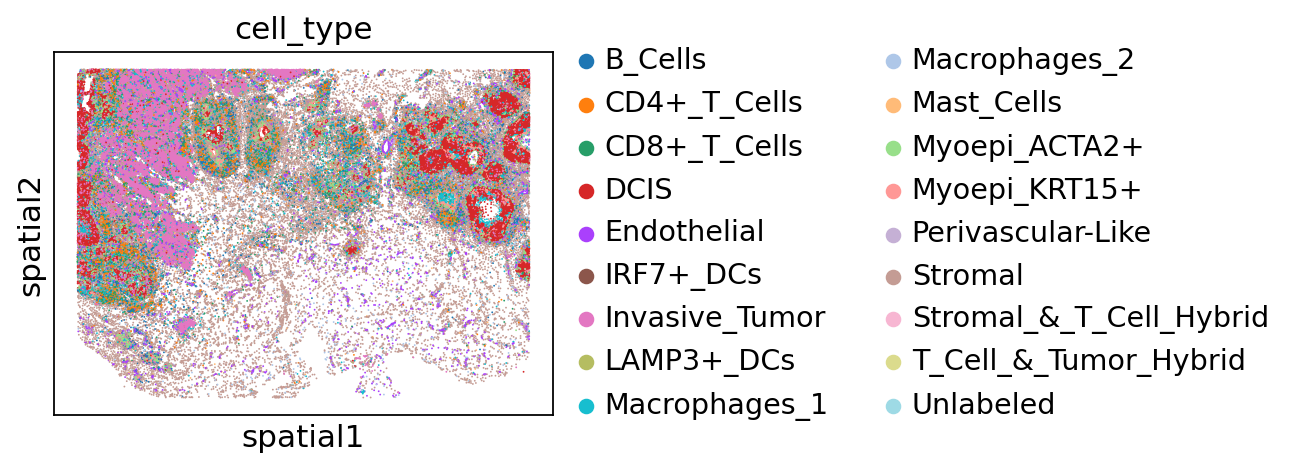

In [5]:
sc.pl.spatial(adata, color="cell_type", spot_size=30)

In [6]:
adata.obs["cell_type"].value_counts()

cell_type
Stromal                    32426
Invasive_Tumor             18185
DCIS                       15993
CD4+_T_Cells                9387
Macrophages_1               8644
CD8+_T_Cells                7493
Endothelial                 7000
B_Cells                     5359
Myoepi_ACTA2+               5324
Myoepi_KRT15+               2636
Macrophages_2               2616
Perivascular-Like            817
Unlabeled                    516
IRF7+_DCs                    454
LAMP3+_DCs                   218
Mast_Cells                   203
Stromal_&_T_Cell_Hybrid       28
T_Cell_&_Tumor_Hybrid          6
Name: count, dtype: int64

## Train NicheVI model

As in the scANVI notebook, we need to register the AnnData object for use in resolVI. Namely, we can ignore the batch parameter because those cells don't have much batch effect to begin with as they are derived from a single slice. However, we will give the celltype labels for resolVI to use. Setting up AnnData computes spatial neighbors within each batch. This step might take minutes for very large datasets. It is important that different slices are used as batch covariate.

In [7]:
setup_kwargs = {
    "sample_key": "sample",
    "labels_key": "cell_type",
    "cell_coordinates_key": "spatial",
    "expression_embedding_key": "X_scANVI",
}

In [11]:
scvi.external.nicheSCVI.preprocessing_anndata(
    adata,
    k_nn=20,
    **setup_kwargs,
)

Saved niche_indexes and niche_distances in adata.obsm

Saved niche_composition in adata.obsm

Saved X_scVI_niche in adata.obsm

In [12]:
scvi.external.nicheSCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="sample",
    **setup_kwargs,
)

INFO     Using column names from columns of adata.obsm['niche_composition']                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [14]:
nichevae = scvi.external.nicheSCVI(
    adata,
    spatial_weight=10,
    prior_mixture=False,
    semisupervised=True,
    linear_classifier=True,
    use_layer_norm="both",
)

nichevae

nicheVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [15]:
nichevae.train(
    max_epochs=500,
    early_stopping=True,
    check_val_every_n_epoch=1,
    batch_size=512,
    plan_kwargs={
        "lr": 5e-4,
    },
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottlen

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: 211.935. Signaling Trainer to stop.


In [16]:
adata.obsm["X_nicheVI"] = nichevae.get_latent_representation()

Again, we may visualize the latent space as well as the inferred labels

In [19]:
sc.pp.neighbors(adata, use_rep="X_nicheVI", n_neighbors=30)
sc.tl.umap(adata)

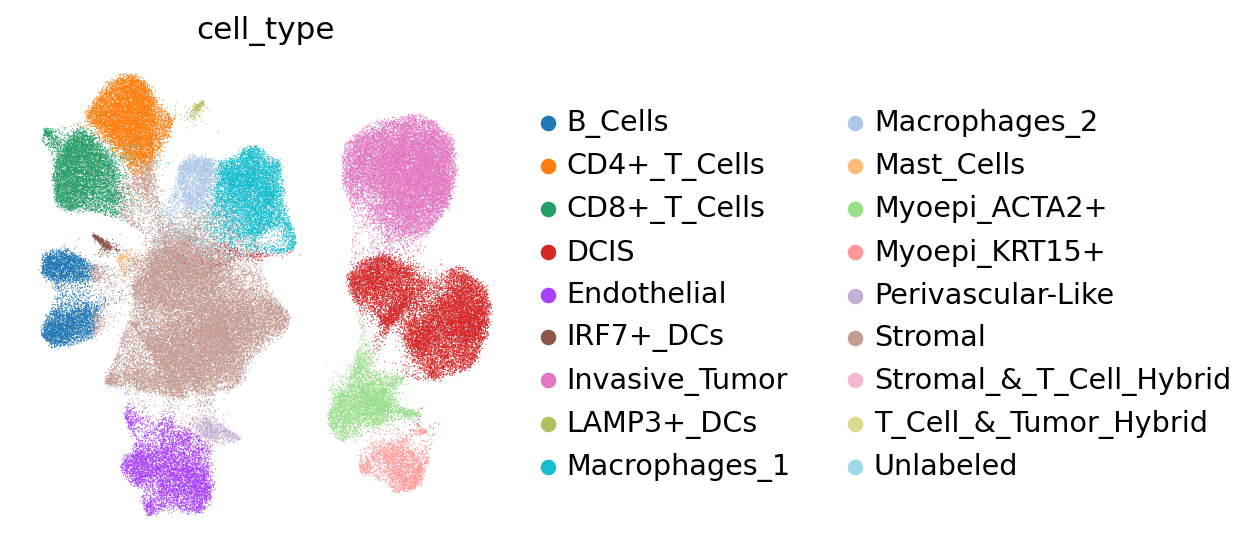

In [20]:
sc.pl.umap(adata, color="cell_type", frameon=False)

# Differential expression analysis

In [ ]:
adata_endothelial = adata[adata.obs["cell_type"] == "Endothelial"].copy()
print(adata_endothelial)

AnnData object with n_obs × n_vars = 7000 × 313
    obs: 'sample', 'x', 'y', 'z', 'observed_x', 'observed_y', 'observed_z', 'fov', 'n_counts', 'index', 
'cell_type', '_scvi_batch', '_scvi_labels', '_scvi_sample'
    var: 'mt'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'pca', 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_scANVI', 'spatial', 'niche_indexes', 'niche_distances', 'niche_composition', 'X_scVI_niche', 
'X_nicheVI', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'counts_log1p', 'counts_wo_bg', 'min_max_scaled', 'min_max_scaled_raw'
    obsp: 'distances', 'connectivities'

In [46]:
sc.pp.neighbors(adata_endothelial, use_rep="X_nicheVI", n_neighbors=30)
sc.tl.umap(adata_endothelial)
sc.tl.leiden(
    adata_endothelial, key_added="leiden_nicheVI", resolution=0.3, flavor="igraph", n_iterations=2
)

In [47]:
adata_endothelial.obs["leiden_nicheVI"].unique()  # check the number of clusters

['0', '2', '4', '1', '3', '5']
Categories (6, object): ['0', '1', '2', '3', '4', '5']

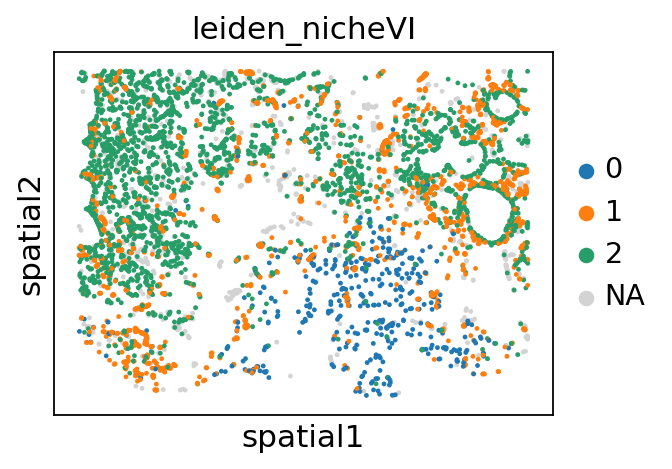

In [56]:
sc.pl.spatial(
    adata_endothelial,
    color="leiden_nicheVI",
    spot_size=80,
    groups=["1", "2", "0"],
    color_map=cc.cm.glasbey_dark,
)

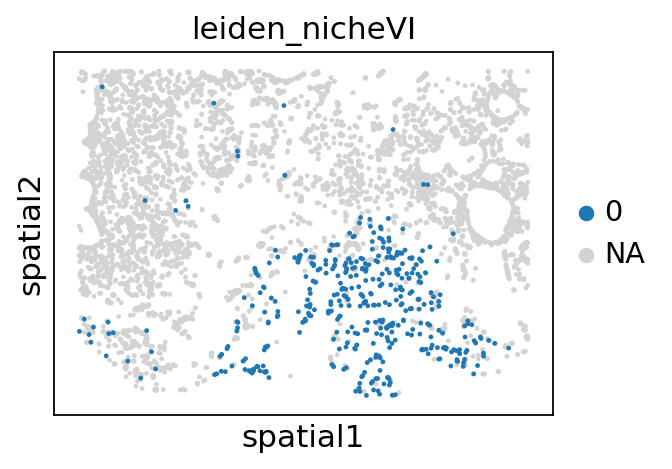

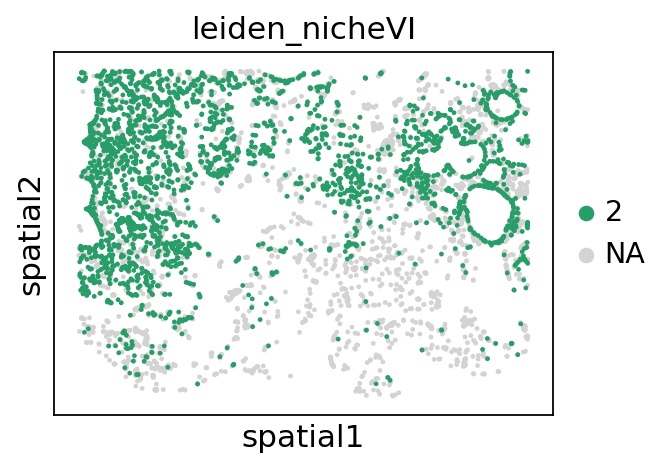

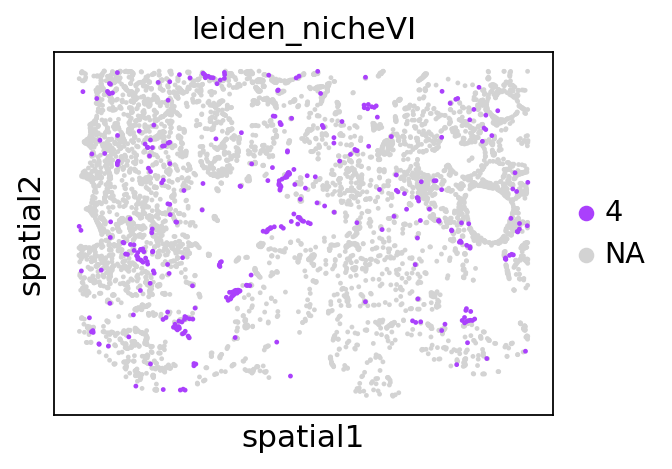

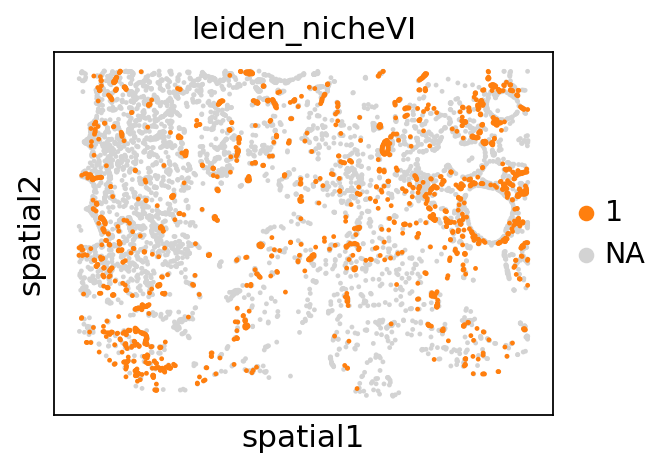

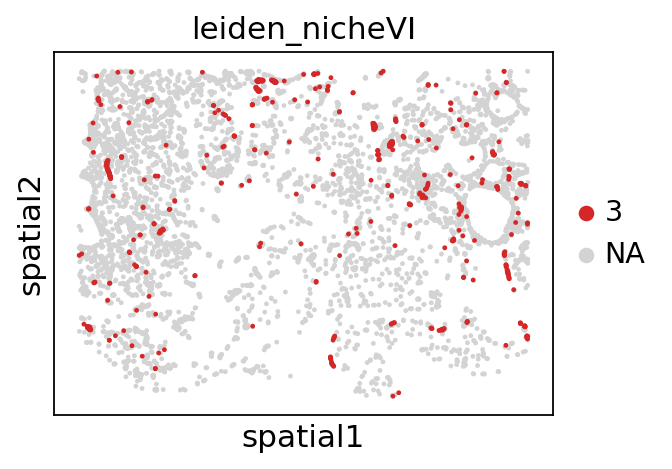

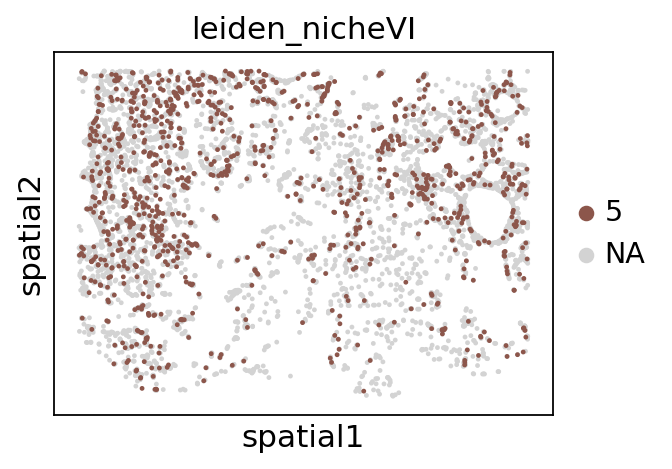

In [48]:
for cluster in adata_endothelial.obs["leiden_nicheVI"].unique():
    sc.pl.spatial(adata_endothelial, color="leiden_nicheVI", spot_size=80, groups=[cluster])

In [ ]:
sc.tl.rank_genes_groups(adata_endothelial, groupby="leiden_nicheVI", method="wilcoxon")
marker_dicts = {
    group: sc.get.rank_genes_groups_df(adata_endothelial, group=group).head(20)["names"].tolist()
    for group in adata_endothelial.obs["leiden_nicheVI"].unique()
}
marker_dicts
# sc.pl.rank_genes_groups_df(adata_endothelial, n_genes=20, ncols=5)

{'0': ['ADH1B',
  'LPL',
  'ADIPOQ',
  'TIMP4',
  'PDK4',
  'BTNL9',
  'CCDC80',
  'CAVIN2',
  'PPARG',
  'AKR1C1',
  'CLDN5',
  'CD14',
  'FGL2',
  'CD163',
  'IGF1',
  'FCER1G',
  'MRC1',
  'SFRP1',
  'CD68',
  'AIF1'],
 '2': ['KDR',
  'BTNL9',
  'TCIM',
  'ZEB1',
  'CLEC14A',
  'ESM1',
  'RAMP2',
  'MMP2',
  'CCND1',
  'JUP',
  'PRDM1',
  'LUM',
  'TCF4',
  'EDNRB',
  'SNAI1',
  'VOPP1',
  'POSTN',
  'SOX17',
  'CD93',
  'SVIL'],
 '4': ['MRC1',
  'FAM107B',
  'CAVIN2',
  'IGF1',
  'ANGPT2',
  'CD9',
  'CCND1',
  'DUSP5',
  'SERPINB9',
  'LRRC15',
  'WARS',
  'DST',
  'MMP2',
  'JUP',
  'CCDC80',
  'DSP',
  'TRIB1',
  'MDM2',
  'FAM49A',
  'ERBB2'],
 '1': ['VWF',
  'AQP1',
  'PECAM1',
  'FLNB',
  'NOSTRIN',
  'EDN1',
  'BACE2',
  'MMRN2',
  'PDK4',
  'SERPINA3',
  'ANKRD29',
  'CAVIN2',
  'CD93',
  'PTGDS',
  'DSP',
  'IL3RA',
  'RAPGEF3',
  'MLPH',
  'TOMM7',
  'AKR1C3'],
 '3': ['CAV1',
  'CXCL12',
  'DST',
  'SOX17',
  'CD93',
  'FLNB',
  'PECAM1',
  'CD9',
  'RAMP2',
  'MMRN2',
  

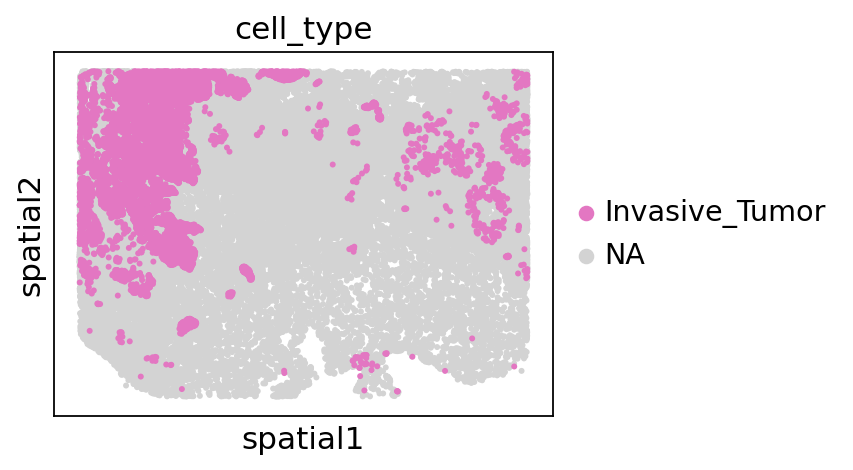

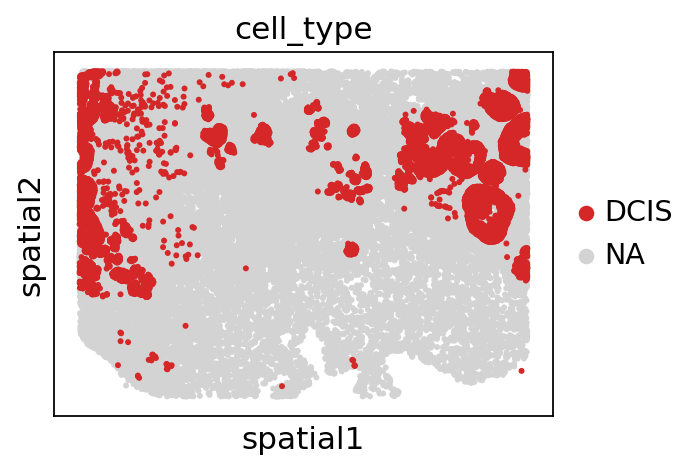

In [36]:
for type in ["Invasive_Tumor", "DCIS"]:
    sc.pl.spatial(adata, color="cell_type", spot_size=100, groups=[type])

In [58]:
adata.obs["max_module"] = "Unknown"
adata.obs.loc[adata.obs["cell_type"] == "Endothelial", "leiden_nicheVI"] = adata_endothelial.obs[
    "leiden_nicheVI"
]

In [75]:
delta_niches = 0.03
delta_markers = 0.15
DELTA = [delta_niches, delta_markers, delta_niches, delta_niches]
FDR = 0.2
G1 = "2"
G2 = "0"
PSEUDO = 1e-4
N_SAMPLES_DE = 1e5
K_NN_DE = 6

DE_1_3 = nichevae.differential_expression(
    adata,
    groupby="leiden_nicheVI",
    group1=G1,
    group2=G2,
    batch_correction=False,
    radius=None,
    k_nn=K_NN_DE,
    delta=DELTA,
    niche_mode=True,
    n_samples_overall=N_SAMPLES_DE,
    fdr_target=FDR,
    pseudocounts=PSEUDO,
)


DE_3_1 = nichevae.differential_expression(
    adata,
    groupby="leiden_nicheVI",
    group1=G2,
    group2=G1,
    batch_correction=False,
    radius=None,
    k_nn=K_NN_DE,
    delta=DELTA,
    niche_mode=True,
    n_samples_overall=N_SAMPLES_DE,
    fdr_target=FDR,
    pseudocounts=PSEUDO,
)

ValueError: value.index does not match parent’s obs names:
Index are different

Attribute "inferred_type" are different
[left]:  string
[right]: integer

In [71]:
# adata.obs.reset_index(inplace=True)

# # Annotate groups
# adata.obs["group"] = "other"  # Default category
# adata.obs.loc[DE_1_3.n1_index, "group"] = "N1"
# adata.obs.loc[DE_1_3.n2_index, "group"] = "N2"

# sc.pl.spatial(
#     adata,
#     spot_size=40,
#     color=["group"],
#     groups=["N1", "N2"],
#     frameon=False,
#     show=False,
#     use_raw=False,
# )

In [63]:
DE_1_3.gpc

GaussianProcessClassifier(kernel=1**2 * RationalQuadratic(alpha=0.1, length_scale=10),
                          n_restarts_optimizer=10, random_state=0)

In [65]:
DE_1_3.gpc.X_

,lfc_median,lfc_median
ADH1B,4.976366,5.112630
ADIPOQ,4.797087,4.794565
LEP,4.213764,3.836265
PDK4,1.641149,1.491600
CTSG,2.338929,2.346547
...,...,...
LPXN,0.001005,0.642087
CD274,-0.003685,-0.002029
SMS,0.002574,0.030005
APOBEC3A,-0.021573,-0.325325


In [66]:
PROBA_TRES = 0.75
PLOT_MARGIN = 0.2

In [67]:
from scvi.external.nichevi.differential_expression import plot_DE_results

/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names
  warnings.warn(


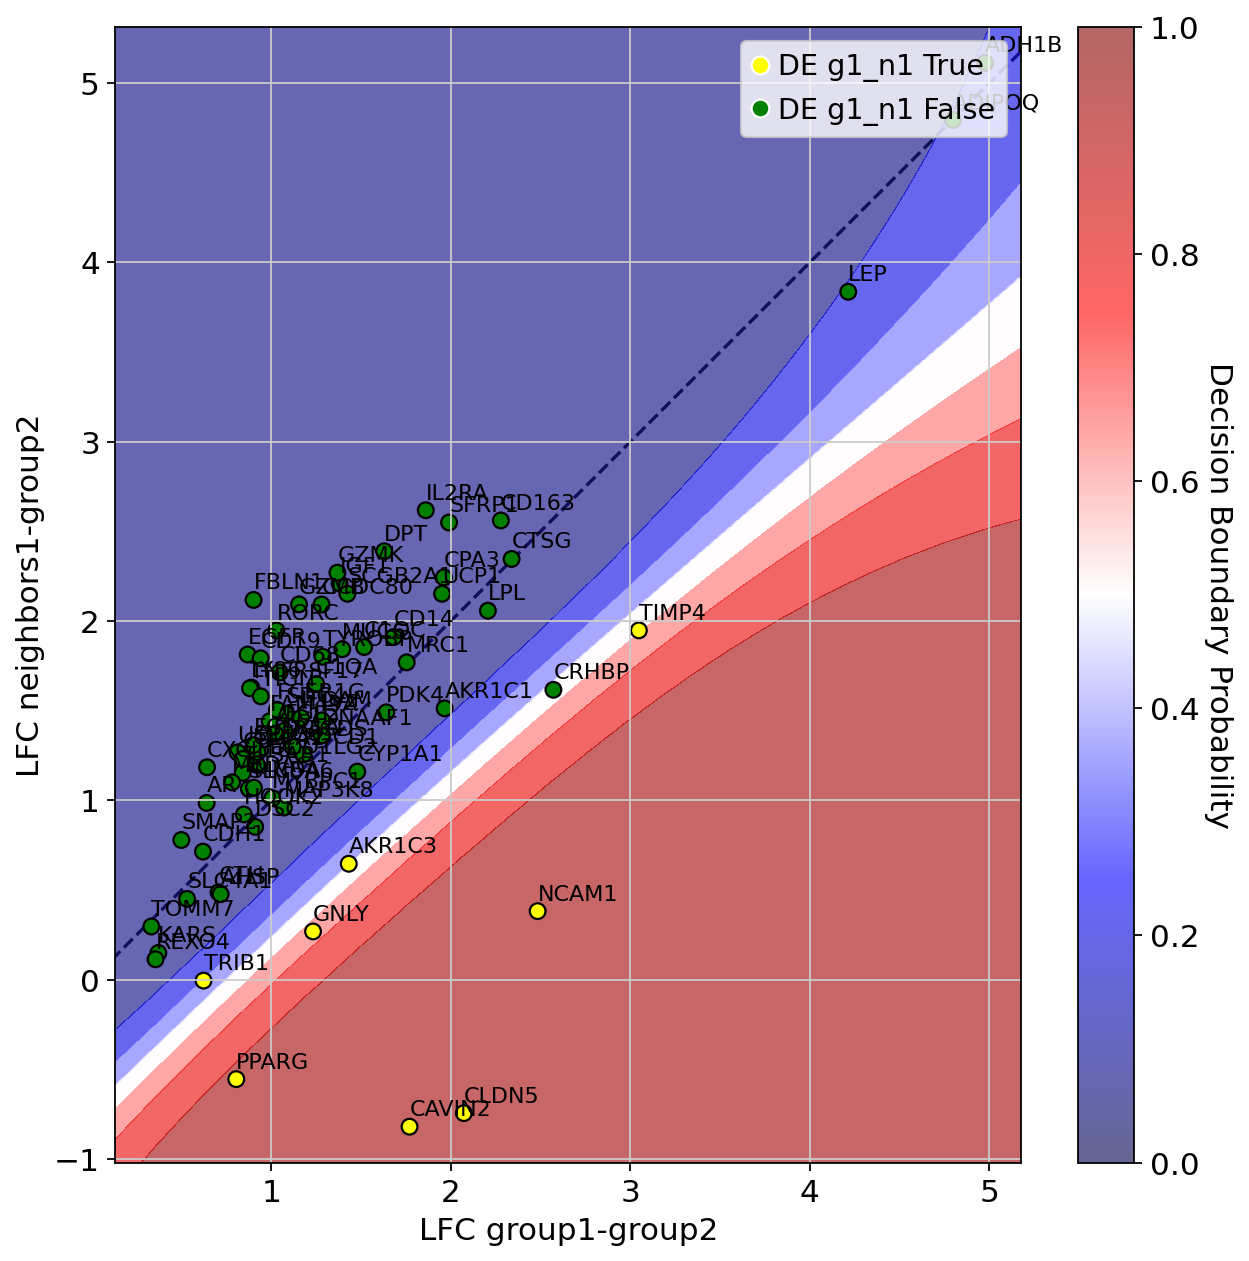

In [68]:
g1_g3_genes = DE_1_3.g1_g2[
    (DE_1_3.g1_g2["lfc_median"] > 0) & (DE_1_3.g1_g2["proba_de"] > PROBA_TRES)
].index

plot_DE_results(
    DE_1_3.gpc,
    filter=g1_g3_genes,
    # path_to_save=f"{setup.FIGURES_2DE_FOLDER}scatter_DE_proseg.svg",
    margin=PLOT_MARGIN,
    # manual_limits=(-0.5, 5.5, -6.25, 4),
)

In [72]:
yellow_genes_g1_g2 = DE_1_3.gpc.confident_genes
blue_genes_g1_g2 = list(set(g1_g3_genes) - set(yellow_genes_g1_g2))

In [ ]:
def get_gene_percentiles_list(adata, gene_list, p, layer=None):
    """
    Calculate the p-percentile of gene expression for a list of genes in an AnnData object.

    Parameters
    ----------
        adata (AnnData): The AnnData object containing expression data.
        gene_list (list): List of gene names for which to compute percentiles.
        p (float): Percentile to compute (between 0 and 100).
        layer (str or None): The layer from which to retrieve expression data.
                             If None, uses `adata.X`.

    Returns
    -------
        list: A list of p-percentile values for the genes, in the same order as gene_list.
              If a gene is not found, its value will be `None`.
    """
    percentiles = []

    for gene in gene_list:
        if gene in adata.var_names:
            if layer:
                data = adata[:, gene].layers[layer].flatten()
            else:
                data = adata[:, gene].X.flatten()

            # Compute the percentile
            percentiles.append(np.percentile(data, p))
        else:
            percentiles.append(None)  # Handle genes not in adata.var_names

    return percentiles

In [ ]:
# plot_endo = False
# gene_list_invasive = ["ESM1", "KRT7", "FOXA1", "KDR", "SNAI1", "NDUFA4L2"]
# percentiles_invasive = get_gene_percentiles_list(
#     adata, gene_list_invasive, 99.9, layer="min_max_scaled"
# )

# sc.pl.spatial(
#     adata=adata_endothelial
#     if plot_endo
#     else adata_not_endo[adata_not_endo.obs[setup.SAMPLE] == sample],
#     spot_size=100 if plot_endo else 40,
#     # color=g3_g1_genes,
#     color=gene_list_invasive,
#     frameon=False,
#     show=False,
#     use_raw=False,
#     wspace=0.4,
#     vmax=percentiles_invasive,
#     # vmax="p99.5",
#     layer="min_max_scaled",
#     cmap="plasma",
# )

In [ ]:
g3_g1_genes = DE_3_1.g1_g2[
    (DE_3_1.g1_g2["lfc_median"] > 0) & (DE_3_1.g1_g2["proba_de"] > PROBA_TRES)
].index

plot_DE_results(
    DE_3_1.gpc,
    filter=g3_g1_genes,
    # path_to_save=f"{setup.FIGURES_2DE_FOLDER}scatter_DE_3_1_proseg.svg",
    margin=PLOT_MARGIN,
    # manual_limits=(-0, 5.0, -3.5, 5),
)

In [73]:
yellow_genes_g2_g1 = DE_3_1.gpc.confident_genes
blue_genes_g2_g1 = list(set(g3_g1_genes) - set(yellow_genes_g2_g1))

AttributeError: 'GaussianProcessClassifier' object has no attribute 'confident_genes'

In [ ]:
# plot_endo = False
# gene_list_stroma = ["EDN1", "CAVIN2", "CLDN5"]
# percentiles_stroma = get_gene_percentiles_list(
#     adata, gene_list_stroma, 99.9, layer="min_max_scaled"
# )

# for sample in adata.obs[setup.SAMPLE].unique().tolist()[:1]:
#     sc.pl.spatial(
#         adata=adata_astro[adata_astro.obs[setup.SAMPLE] == sample]
#         if plot_endo
#         else adata_not_endo[adata_not_endo.obs[setup.SAMPLE] == sample],
#         spot_size=100 if plot_endo else 40,
#         # color=g3_g1_genes,
#         color=gene_list_stroma,
#         frameon=False,
#         show=False,
#         use_raw=False,
#         wspace=0.4,
#         # vmax=percentiles_stroma,
#         # vmax="p99.5",
#         layer="min_max_scaled",
#         cmap="plasma",
#     )

#     if plot_endo:
#         plt.savefig(f"{figure_dir}_proseg_stroma_endo.svg", bbox_inches="tight", dpi=1000)
#     else:
#         plt.savefig(f"{figure_dir}_proseg_stroma_not_endo.svg", bbox_inches="tight", dpi=1000)
